In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [3]:
columns = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'
]
df = pd.DataFrame(data, columns=columns)
df['PRICE'] = target
print(df.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2  


In [4]:
# Cleaning the data
print("Checking for missing values:")
print(df.isnull().sum())  # Should be all zeros—nice and clean!
df['RM_TAX_RATIO'] = df['RM'] / df['TAX']
df['LogPRICE'] = np.log1p(df['PRICE'])

Checking for missing values:
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
PRICE      0
dtype: int64


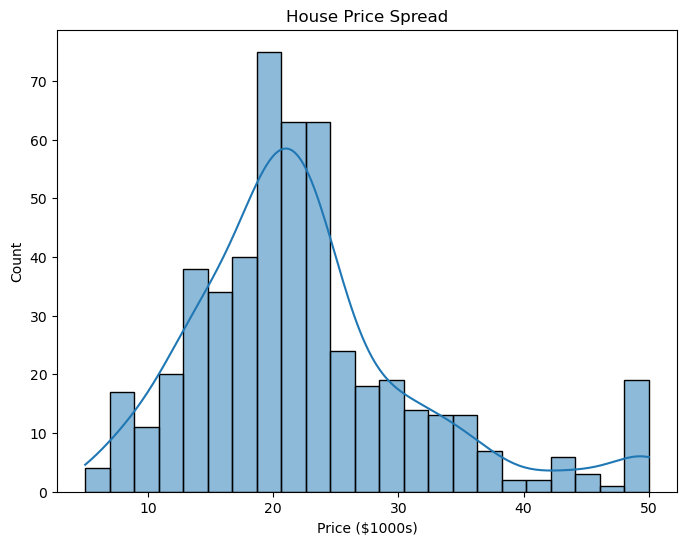

In [5]:
# Picture 1: Price spread
plt.figure(figsize=(8,6))
sns.histplot(df['PRICE'], kde=True)
plt.title('House Price Spread')
plt.xlabel('Price ($1000s)')
plt.show()

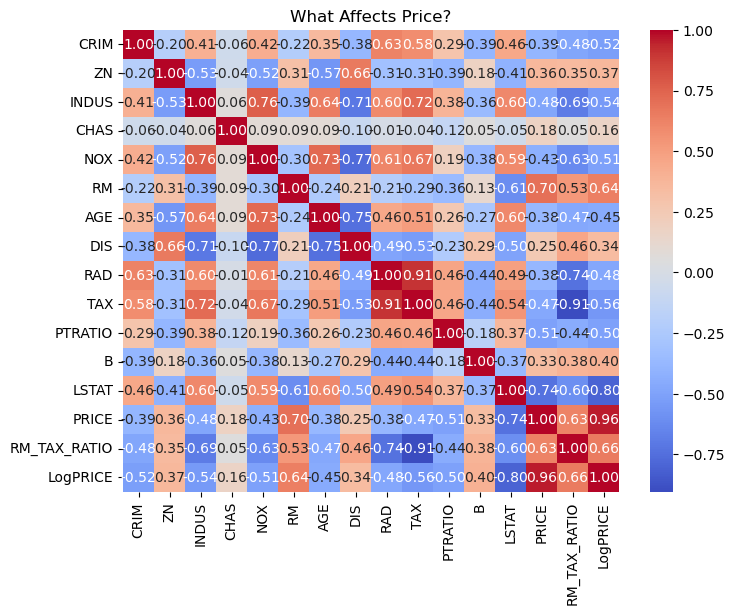

In [6]:
# Picture 2: Connections
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('What Affects Price?')
plt.show()

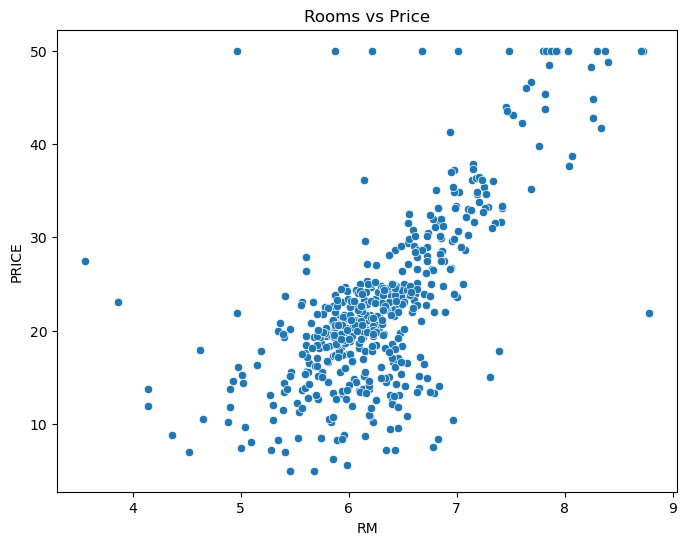

In [7]:
# Picture 3: Rooms vs. Price
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='RM', y='PRICE')
plt.title('Rooms vs Price')
plt.show()

In [8]:
X = df.drop(['PRICE', 'LogPRICE'], axis=1) # The clues
y = df['LogPRICE'] # what we're guessing
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(404, 14) (102, 14)


In [9]:
# Here it is to teach the model or computer
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

In [10]:
# Testing our guesses and check how good we are in test model with pedicted model
y_pred = model.predict(X_test)
print("First 5 real prices:", y_test[:5].values)
print("First 5 guessed prices:", y_pred[:5])

First 5 real prices: [3.20274644 3.5085559  2.68102153 3.16968558 2.83907846]
First 5 guessed prices: [3.19895408 3.44148483 2.84628916 3.18139481 2.84930221]


In [11]:
# test with real predicted model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Our average error (RMSE): ${rmse:.2f} thousand")

Our average error (RMSE): $0.15 thousand


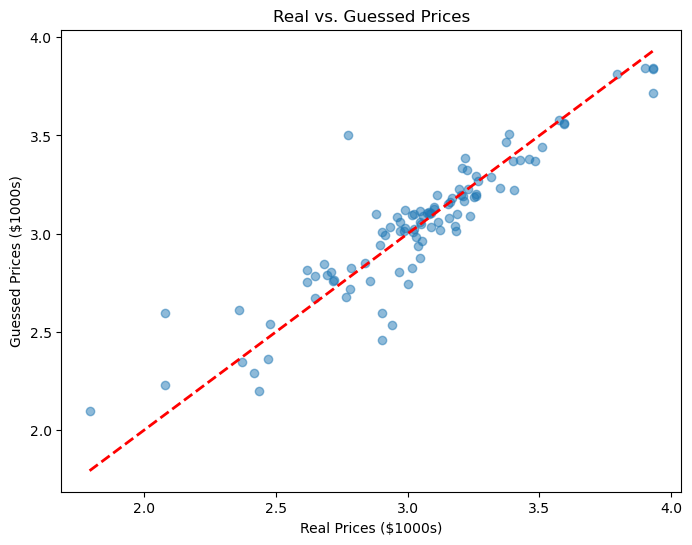

In [12]:
# Real vs. Guessed Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Real Prices ($1000s)')
plt.ylabel('Guessed Prices ($1000s)')
plt.title('Real vs. Guessed Prices')
plt.show()

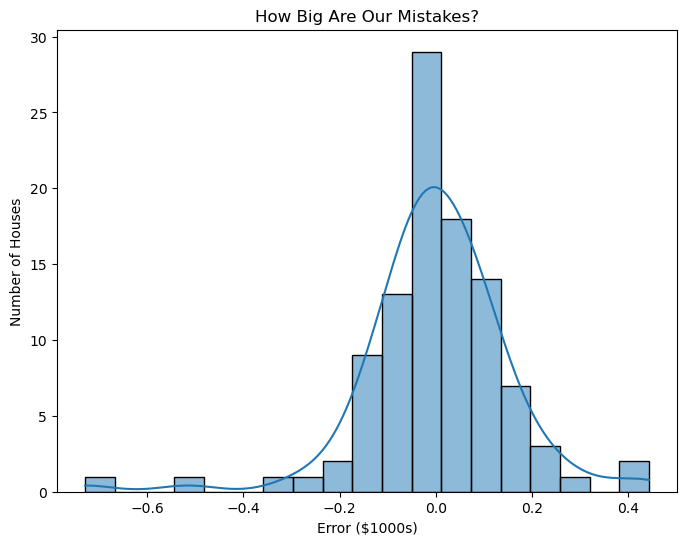

In [13]:
# Error Distribution
errors = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(errors, kde=True)
plt.xlabel('Error ($1000s)')
plt.ylabel('Number of Houses')
plt.title('How Big Are Our Mistakes?')
plt.show()

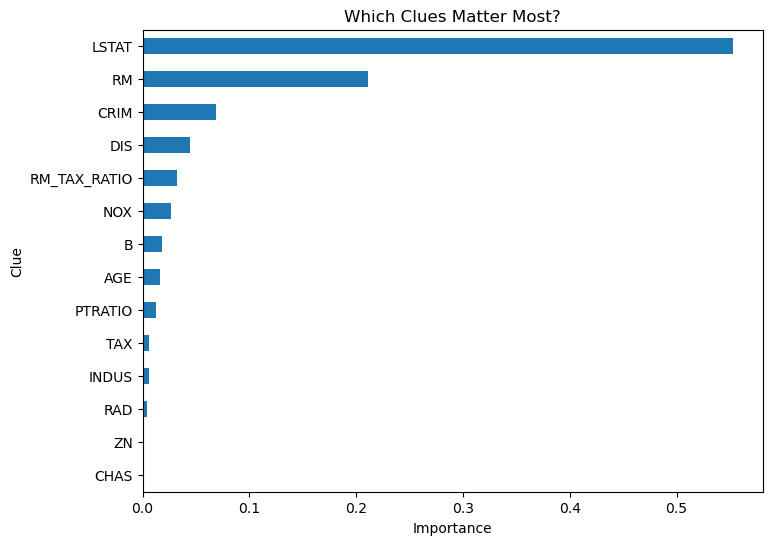

In [14]:
# Feature Importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values()
plt.figure(figsize=(8, 6))
feature_importance.plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Clue')
plt.title('Which Clues Matter Most?')
plt.show()

In [15]:
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")

R² Score: 0.84


In [16]:
# Deployment
# Predict for one house
new_house = X_test.iloc[0]
print("Here’s the house we’re guessing for:")
print(new_house)
new_house_array = new_house.values.reshape(1, -1)
predicted_price = model.predict(new_house_array)[0]
print(f"Predicted Price: ${predicted_price * 1000:.2f}")

Here’s the house we’re guessing for:
CRIM              0.091780
ZN                0.000000
INDUS             4.050000
CHAS              0.000000
NOX               0.510000
RM                6.416000
AGE              84.100000
DIS               2.646300
RAD               5.000000
TAX             296.000000
PTRATIO          16.600000
B               395.500000
LSTAT             9.040000
RM_TAX_RATIO      0.021676
Name: 173, dtype: float64
Predicted Price: $3198.95


/home/vel/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [17]:
# Get the 13 original inputs
crime = float(input("Crime rate (e.g., 0.02731): "))
zn = float(input("Zoning (e.g., 0.0): "))
indus = float(input("Industry nearby (e.g., 7.07): "))
chas = float(input("Near river? (0 or 1): "))
nox = float(input("Air pollution (e.g., 0.469): "))
rooms = float(input("Number of rooms (e.g., 6.421): "))
age = float(input("Age of house (e.g., 78.9): "))
dis = float(input("Distance to jobs (e.g., 4.9671): "))
rad = float(input("Highway access (e.g., 2.0): "))
tax = float(input("Tax rate (e.g., 242.0): "))
ptratio = float(input("Pupil-teacher ratio (e.g., 17.8): "))
b = float(input("Black population factor (e.g., 396.9): "))
lstat = float(input("% lower status (e.g., 9.14): "))

# Calculate RM_TAX_RATIO from rooms and tax
rm_tax_ratio = rooms / tax

Crime rate (e.g., 0.02731):  0.02547
Zoning (e.g., 0.0):  0.0
Industry nearby (e.g., 7.07):  8.45
Near river? (0 or 1):  1
Air pollution (e.g., 0.469):  0.354
Number of rooms (e.g., 6.421):  5.124
Age of house (e.g., 78.9):  75.1
Distance to jobs (e.g., 4.9671):  4.5678
Highway access (e.g., 2.0):  2.0
Tax rate (e.g., 242.0):  475.5
Pupil-teacher ratio (e.g., 17.8):  11.5
Black population factor (e.g., 396.9):  180.4
% lower status (e.g., 9.14):  7.2


In [20]:
# Add it to the list—now 14 features!
user_house = [crime, zn, indus, chas, nox, rooms, age, dis, rad, tax, ptratio, b, lstat, rm_tax_ratio]
user_house_array = np.array(user_house).reshape(1, -1)
user_price = model.predict(user_house_array)[0]
print(f"Your house might be worth: ${user_price * 1000:.2f}")

Your house might be worth: $3084.37


/home/vel/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [19]:
# Save the model
joblib.dump(model, 'house_price_model.pkl')
print("Model saved! Load it later with: model = joblib.load('house_price_model.pkl')")

Model saved! Load it later with: model = joblib.load('house_price_model.pkl')
